In [71]:
import nibabel as nib #pip install nibabel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as op
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm
import os
from scipy.stats import zscore
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
from sklearn.decomposition import PCA, FastICA

https://openneuro.org/datasets/ds002322/versions/1.0.4  (alice)

https://openneuro.org/datasets/ds002739/versions/1.0.0  (autre)

In [54]:
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

# def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
def direct_file_download_open_neuro(sub_id, sub_id_number, dataset_id, dataset_version, subject_fmap):
    path = os. getcwd()
    subject = 'sub-'+sub_id_number
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    func_path = op.join(path, 'sub_'+subject_fmap, 'func')
    mkdir_no_exist(op.join(path, 'sub_'+subject_fmap))
    mkdir_no_exist(func_path)
    file_func = f'sub-{sub_id_number}_task-alice_bold.nii.gz'

    anat_path = op.join(path, 'sub_'+subject_fmap, 'anat')
    mkdir_no_exist(op.join(path, 'sub_'+subject_fmap))
    mkdir_no_exist(anat_path)
    file_anat = f'sub-{sub_id_number}_T1w.nii.gz'
    
    derivative_path = op.join(path, 'sub_'+subject_fmap, 'derivative')
    mkdir_no_exist(op.join(path, 'sub_'+subject_fmap))
    mkdir_no_exist(derivative_path)
    file_derivative = f'sub-{sub_id_number}_task-alice_bold_preprocessed.nii.gz'
    
    download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, 'func', file_func)
    print('Attempting download from ', download_link)
    download_url(download_link, op.join(func_path, file_func))
    print('Ok')
    
    download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, 'anat', file_anat)
    print('Attempting download from ', download_link)
    download_url(download_link, op.join(anat_path, file_anat))
    print('Ok')
    
    download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, 'derivatives',subject, file_derivative)
    print('Attempting download from ', download_link)
    download_url(download_link, op.join(derivative_path, file_derivative))
    print('Ok')


In [55]:

dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

# Download one subject's data from each dataset
for i in subject_fmap:
    name='sub-'+i
    print(name)
    direct_file_download_open_neuro(sub_id = name, 
                                    sub_id_number = i,
                                    dataset_id = dataset_fmap,
                                    dataset_version='1.0.0',
                                    subject_fmap = i)

    # direct_file_download_open_neuro(file_list=['sub-001_task-sitrep_run-04_events.tsv'], 
    #                                 file_types=['func'], 
    #                                 dataset_id=dataset_fmap, 
    #                                 dataset_version='1.0.0', 
    #                                 save_dirs=[func_path])

sub-18
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-18:func:sub-18_task-alice_bold.nii.gz


sub-18:func:sub-18_task-alice_bold.nii.gz: 0.00B [00:00, ?B/s]

sub-18:func:sub-18_task-alice_bold.nii.gz: 105MB [00:27, 3.86MB/s]                               


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-18:anat:sub-18_T1w.nii.gz


sub-18:anat:sub-18_T1w.nii.gz: 10.1MB [00:04, 2.03MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-18:sub-18_task-alice_bold_preprocessed.nii.gz


derivatives:sub-18:sub-18_task-alice_bold_preprocessed.nii.gz: 287MB [01:23, 3.45MB/s]                               


Ok
sub-22
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-22:func:sub-22_task-alice_bold.nii.gz


sub-22:func:sub-22_task-alice_bold.nii.gz: 108MB [00:23, 4.71MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-22:anat:sub-22_T1w.nii.gz


sub-22:anat:sub-22_T1w.nii.gz: 9.82MB [00:05, 1.90MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz


derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz: 289MB [00:53, 5.41MB/s]                               


Ok
sub-35
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-35:func:sub-35_task-alice_bold.nii.gz


sub-35:func:sub-35_task-alice_bold.nii.gz: 110MB [00:24, 4.59MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/sub-35:anat:sub-35_T1w.nii.gz


sub-35:anat:sub-35_T1w.nii.gz: 10.6MB [00:05, 2.00MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-35:sub-35_task-alice_bold_preprocessed.nii.gz


derivatives:sub-35:sub-35_task-alice_bold_preprocessed.nii.gz: 291MB [01:01, 4.71MB/s]                               

Ok


In [11]:
#events = pd.read_csv(op.join(func_path, 'sub-001_task-sitrep_run-04_events.tsv'), sep='\t')

### Load the data


In [58]:
current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivative/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)
print(data.shape)

(79, 95, 68, 372)


### Preprocess the data

In [59]:
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print(vol_shape, n_vols)

(79, 95, 68) 372


In [16]:
N = np.prod(vol_shape)
#we take the full matrux as time series
data_ = data.reshape(N, n_vols).T
#reshape in function of the time axis and take the transpose

In [36]:
#to get the PCA need the row means in a times_axis_shape x N
row_means = np.mean(data_, axis=1)
row_means = np.outer(row_means, np.ones(N))
#substract the mean from the time axis
X = data_ - row_means

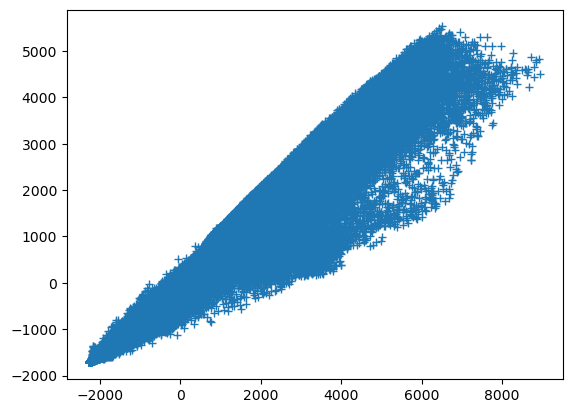

In [30]:
plt.plot(X[0], X[1], '+')

### PCA 

In [37]:
# compute the covariance matrix
covariance_matrix = X.dot(X.T)

# Get the U, S, VT matrices
U, S, VT = np.linalg.svd(covariance_matrix)

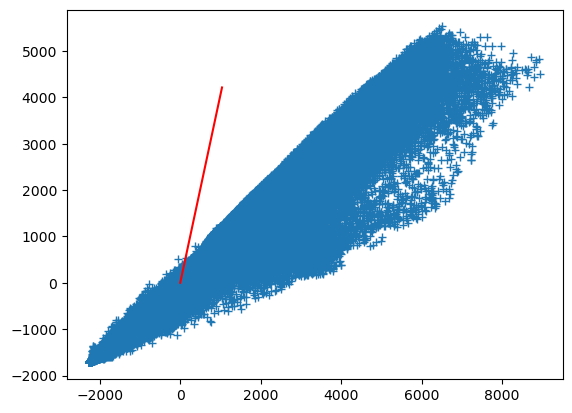

In [38]:
# plot the signal in the first row against 
#signal in the second row

plt.plot(X[0], X[1], '+')
scaled_u = U[0, : ] * -15000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r')

In [39]:
# Scalar projection
C = U.T.dot(data_)

C_vols = C.T.reshape(vol_shape + (n_vols,))

# break 4D array in 3D
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

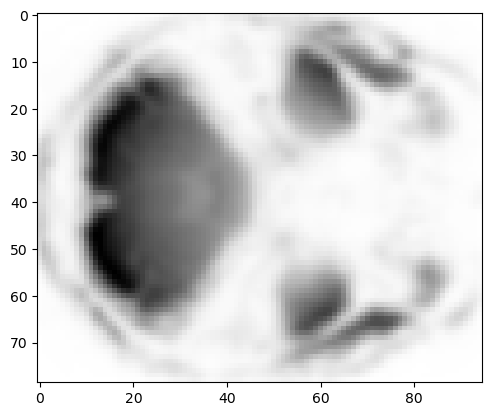

In [40]:
plt.imshow(vol0[:, :, 10], cmap='gray')

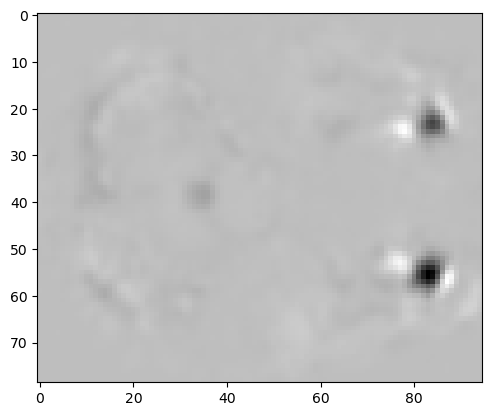

In [41]:
plt.imshow(vol1[:, :, 10], cmap='gray')

### Spatial & Temporal ICA

### Group ICA

In [64]:
#find x,y,z shapes on functional data of first subject
affine = img.affine
print(img.shape)
x,y,z,vol = img.shape
#choose N_vol = 200
N_vol = 200
N_subj = 3
N_tot = N_vol * N_subj

X = np.zeros((N_tot, x*y*z))
i = 0
n_nii = 0
nb_subj_counted = 0
for n_nii in range(N_subj):
    print('Loading subject ', n_nii+1)
    img = nib.load(current_directory + '/sub_'+subject_fmap[n_nii] +'/derivative/sub-'+subject_fmap[n_nii]+'_task-alice_bold_preprocessed.nii.gz')
    data = np.asanyarray(img.dataobj)
    for j in range(N_vol):
        X[i] = data[:, :, :, j].reshape(x*y*z)
        i += 1
X = zscore(X, axis=1)
X = np.nan_to_num(X,0)


(79, 95, 68, 372)
Loading subject  0
Loading subject  1
Loading subject  2


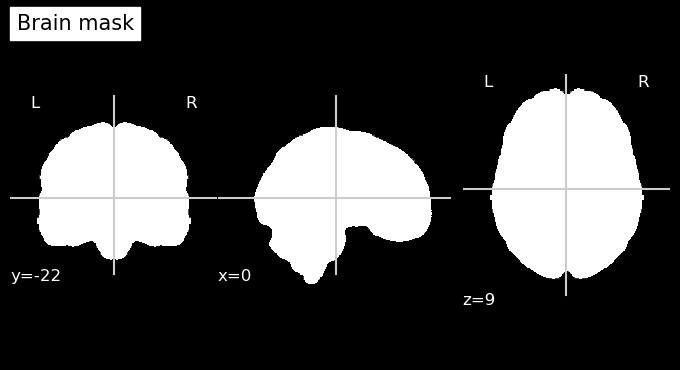

In [73]:
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, title='Brain mask',black_bg=True, colorbar=False)

In [77]:
S_dict = {}
n_components = [4]

for i in n_components:
    n2=2*i
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)
    print('Running FastICA with n = %d components'%i)
    #ica = FastICA(n_components=i,random_state=1, max_iters=200)
    ica = FastICA(n_components=i,random_state=1)
    S_ = ica.fit_transform(H)
    #W_ = ica.compents_
    S_dict[i]=S_
    print('Done')

Running FastICA with n = 4 components
Done
